In [1]:
UPDATE = "asynchronous"
DIRECTORY = "models/random_nk3"
NUM_RUNS = 100
DEBUG = True
row_wise_average = True

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np

from pyboolnet.external.bnet2primes import bnet_text2primes
from pyboolnet.file_exchange import primes2bnet
from pyboolnet.prime_implicants import percolate
from pyboolnet.state_transition_graphs import primes2stg

from attractors import get_predicted_attractors
from basins import get_convergence_matrix
from grouping import sd_grouping, null_grouping, random_grouping
from matrix_operations import nsquare, compress_matrix, expand_matrix, get_rms_diff, get_dkl, get_confusion_matrix
from transition_matrix import get_transition_matrix, get_uniform_matrix


def get_data(bnet, data = {}, update="asynchronous", num_runs=100, DEBUG = False):

    # initialize data
    data["rmsd"] = {}
    data["dkl"] = {}
    data["reachability"] = {}
    
    primes = bnet_text2primes(bnet)
    primes = {key: primes[key] for key in sorted(primes)}
    # Percolate constant nodes and remove them
    percolated_primes = percolate(primes, remove_constants=True, copy=True)
    if len(percolated_primes) == 0:
        return data
    percolated_bnet = primes2bnet(percolated_primes)
    
    stg = primes2stg(percolated_primes, update)
    
    T = get_transition_matrix(stg, DEBUG=DEBUG)
    T_inf = nsquare(T, 20, DEBUG=DEBUG)
    
    sd_indices = sd_grouping(percolated_bnet, DEBUG=DEBUG)
    Tsd = compress_matrix(T, sd_indices, DEBUG=DEBUG)
    Tsd_inf = nsquare(Tsd, 20, DEBUG=DEBUG)
    Tsd_inf_expanded = expand_matrix(Tsd_inf, sd_indices, DEBUG=DEBUG)
    
    null_indices = null_grouping(percolated_bnet, DEBUG=DEBUG)
    Tnull = compress_matrix(T, null_indices, DEBUG=DEBUG)
    Tnull_inf = nsquare(Tnull, 20, DEBUG=DEBUG)
    Tnull_inf_expanded = expand_matrix(Tnull_inf, null_indices, DEBUG=DEBUG)
    
    predicted_attractor_indices = get_predicted_attractors(Tsd, sd_indices, as_indices=True, DEBUG=DEBUG)
    
    T_convergence_matrix = get_convergence_matrix(T_inf, predicted_attractor_indices, DEBUG=DEBUG)
    Tsd_convergence_matrix = get_convergence_matrix(Tsd_inf_expanded, predicted_attractor_indices, DEBUG=DEBUG)
    Tnull_convergence_matrix = get_convergence_matrix(Tnull_inf_expanded, predicted_attractor_indices, DEBUG=DEBUG)
    uniform_convergence_matrix = get_uniform_matrix(2**(len(percolated_primes)), len(predicted_attractor_indices))

    # Get comparison results
    data["rmsd"]["Tsd"] = get_rms_diff(T_convergence_matrix, Tsd_convergence_matrix, partial=True, row_wise_average=row_wise_average, DEBUG=DEBUG)
    data["rmsd"]["Tnull"] = get_rms_diff(T_convergence_matrix, Tnull_convergence_matrix, partial=True, row_wise_average=row_wise_average, DEBUG=DEBUG)
    data["rmsd"]["uniform"] = get_rms_diff(T_convergence_matrix, uniform_convergence_matrix, partial=True, row_wise_average=row_wise_average, DEBUG=DEBUG)

    data["dkl"]["Tsd"] = get_dkl(T_convergence_matrix, Tsd_convergence_matrix, partial=True, row_wise_average=row_wise_average, DEBUG=DEBUG)
    data["dkl"]["Tnull"] = get_dkl(T_convergence_matrix, Tnull_convergence_matrix, partial=True, row_wise_average=row_wise_average, DEBUG=DEBUG)
    data["dkl"]["uniform"] = get_dkl(T_convergence_matrix, uniform_convergence_matrix, partial=True, row_wise_average=row_wise_average, DEBUG=DEBUG)
    
    data["reachability"]["Tsd"] = get_confusion_matrix(T_convergence_matrix, Tsd_convergence_matrix, partial=True, DEBUG=DEBUG)
    data["reachability"]["Tnull"] = get_confusion_matrix(T_convergence_matrix, Tnull_convergence_matrix, partial=True, DEBUG=DEBUG)
    data["reachability"]["uniform"] = get_confusion_matrix(T_convergence_matrix, uniform_convergence_matrix, partial=True, DEBUG=DEBUG)

    # Get convergence probability matrix for the random matrix and get comparison results
    data["rmsd"]["Trandom"] = []
    data["dkl"]["Trandom"] = []
    data["reachability"]["Trandom_TP"] = []
    data["reachability"]["Trandom_FP"] = []
    data["reachability"]["Trandom_TN"] = []
    data["reachability"]["Trandom_FN"] = []
    for i in range(num_runs):
        random_indices = random_grouping(sd_indices, null_indices, seed=i, DEBUG=DEBUG)
        Trandom = compress_matrix(T, random_indices, DEBUG=DEBUG)
        Trandom_inf = nsquare(Trandom, 20, DEBUG=DEBUG)
        Trandom_inf_expanded = expand_matrix(Trandom_inf, random_indices, DEBUG=DEBUG)
        Trandom_convergence_matrix = get_convergence_matrix(Trandom_inf_expanded, predicted_attractor_indices, DEBUG=DEBUG)

        data["rmsd"]["Trandom"].append(get_rms_diff(T_convergence_matrix, Trandom_convergence_matrix, partial=True, row_wise_average=row_wise_average, DEBUG=DEBUG))
        data["dkl"]["Trandom"].append(get_dkl(T_convergence_matrix, Trandom_convergence_matrix, partial=True, row_wise_average=row_wise_average, DEBUG=DEBUG))

        confusion_matrix_random = get_confusion_matrix(T_convergence_matrix, Trandom_convergence_matrix, partial=True, DEBUG=DEBUG)
        data["reachability"]["Trandom_TP"].append(confusion_matrix_random[0])
        data["reachability"]["Trandom_FP"].append(confusion_matrix_random[1])
        data["reachability"]["Trandom_TN"].append(confusion_matrix_random[2])
        data["reachability"]["Trandom_FN"].append(confusion_matrix_random[3])
    
    return data

In [3]:
all_data = {}

# Iterate over the files in the directory
for filename in sorted(os.listdir(DIRECTORY)):

    file_path = os.path.join(DIRECTORY, filename)
    
    # Check if it's a file (not a directory)
    if not os.path.isfile(file_path):
        continue

    # Open and read the file
    with open(file_path, 'r') as file:
        print(f"Reading file: {filename}")
        content = file.read()
        
    data = get_data(bnet=content, data={}, update=UPDATE, num_runs=NUM_RUNS, DEBUG=DEBUG)

    all_data[filename] = data

Reading file: n010_000.bnet
Reading file: n010_001.bnet
Reading file: n010_002.bnet
Reading file: n010_003.bnet
Reading file: n010_004.bnet
duplicates={'000000001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000000101': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000000111': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000010100': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010101': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010110': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010111': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000100001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000100100': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], 

In [4]:
for bnet in all_data:
    if len(all_data[bnet]["rmsd"]) == 0:
        print(bnet)
        continue
    print(bnet,
          all_data[bnet]["rmsd"]["Tsd"],
          np.mean(all_data[bnet]["rmsd"]["Trandom"]),
          all_data[bnet]["rmsd"]["Tnull"],
          all_data[bnet]["rmsd"]["uniform"],

          all_data[bnet]["dkl"]["Tsd"],
          np.mean(all_data[bnet]["dkl"]["Trandom"]),
          all_data[bnet]["dkl"]["Tnull"],
          all_data[bnet]["dkl"]["uniform"]
          )

n010_000.bnet 0.03376652386268181 0.3926758564642494 0.3929485580333662 0.42419855803336615 0.015284236628072732 0.4776216183815631 0.4781373415873135 0.5214590403723101
n010_001.bnet 0.16284215638234925 0.2723634371643033 0.27661783563471365 0.31093558918869846 0.31127453738744004 1.0338699309369526 1.068622580675433 1.1734131457803492
n010_002.bnet 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
n010_003.bnet 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
n010_004.bnet 0.17540372177020105 0.3213403015901918 0.32196698993709033 0.3297460280202017 0.3670680804380759 0.8780064359892903 0.881313655850859 0.9148934639001611
n010_005.bnet 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
n010_006.bnet 0.20200652359023916 0.2613781532600104 0.26153193635946836 0.26250849885946836 0.15527809796223913 0.24755822718914824 0.24791873791519808 0.24927254100222923
n010_007.bnet 0.06785600931610797 0.07849832839605445 0.07773875885603371 0.10663352265806209 0.02402841522530043 0.03388067704513944 0.03376035811075151 0.04740255072938404
n010_008.

In [5]:
def plot_rmsd_and_dkl(rmsd, dkl):

    # Create histograms of precision and recall
    plt.figure(figsize=(10, 6))

    # Plotting the histogram for Precision
    plt.subplot(1, 2, 1)
    plt.hist(rmsd, bins=10, color='blue', alpha=0.7)
    plt.title('RMSD Histogram')
    plt.xlabel('RMSD')
    plt.ylabel('Frequency')
    plt.xlim(0, 2)
    plt.ylim(0, 30)

    # Plotting the histogram for Recall
    plt.subplot(1, 2, 2)
    plt.hist(dkl, bins=10, color='green', alpha=0.7)
    plt.title('Dkl Histogram')
    plt.xlabel('normalized Dkl')
    plt.ylabel('Frequency')
    plt.xlim(0, 2)
    plt.ylim(0, 30)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

0.04798846695011638 0.08052954946384812
0.27666686513914995 0.3580443563387486


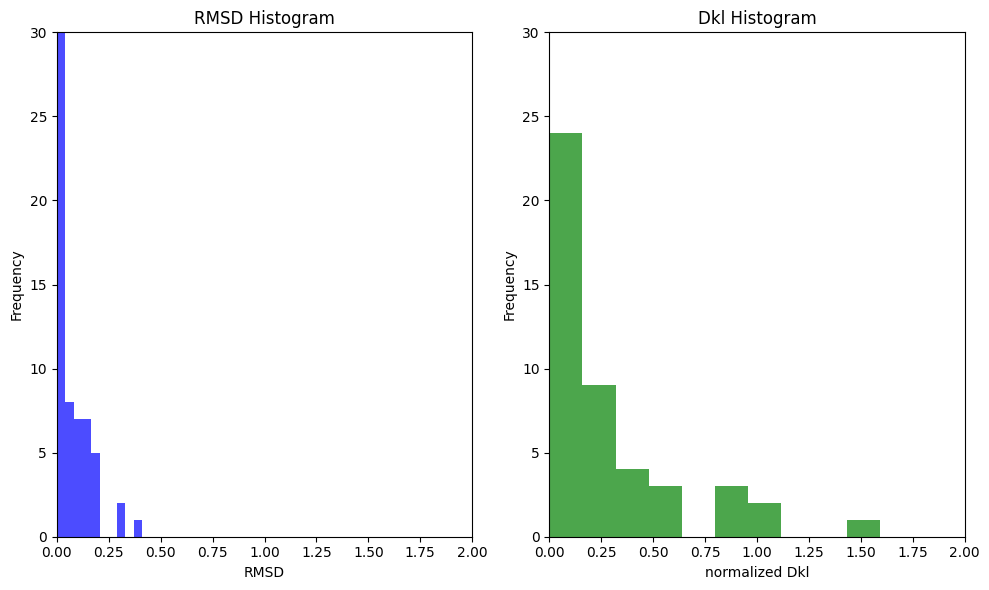

In [6]:
rmsd = []
dkl = []
for bnet in all_data:
    if len(all_data[bnet]["rmsd"]) == 0:
        continue
    rmsd.append(all_data[bnet]["rmsd"]["Tsd"])
    if all_data[bnet]["dkl"]["uniform"] != 0:
        dkl.append(all_data[bnet]["dkl"]["Tsd"] / all_data[bnet]["dkl"]["uniform"])

print(np.mean(rmsd), np.std(rmsd))
print(np.mean(dkl), np.std(dkl))

plot_rmsd_and_dkl(rmsd, dkl)

In [7]:
for bnet in all_data:
    if len(all_data[bnet]["reachability"]) == 0:
        print(bnet)
        continue
    print(bnet,
          all_data[bnet]["reachability"]["Tsd"][0],
          all_data[bnet]["reachability"]["Tsd"][1],
          all_data[bnet]["reachability"]["Tsd"][2],
          all_data[bnet]["reachability"]["Tsd"][3],

          np.mean(all_data[bnet]["reachability"]["Trandom_TP"]),
          np.mean(all_data[bnet]["reachability"]["Trandom_FP"]),
          np.mean(all_data[bnet]["reachability"]["Trandom_TN"]),
          np.mean(all_data[bnet]["reachability"]["Trandom_FN"]),

          all_data[bnet]["reachability"]["Tnull"][0],
          all_data[bnet]["reachability"]["Tnull"][1],
          all_data[bnet]["reachability"]["Tnull"][2],
          all_data[bnet]["reachability"]["Tnull"][3],

          all_data[bnet]["reachability"]["uniform"][0],
          all_data[bnet]["reachability"]["uniform"][1],
          all_data[bnet]["reachability"]["uniform"][2],
          all_data[bnet]["reachability"]["uniform"][3],
          )

n010_000.bnet 1408 0 640 0 1408.0 576.0 64.0 0.0 1408 576 64 0 1408 640 0 0
n010_001.bnet 116 26 178 0 116.0 179.96 24.04 0.0 116 180 24 0 116 204 0 0
n010_002.bnet 128 0 0 0 128.0 0.0 0.0 0.0 128 0 0 0 128 0 0 0
n010_003.bnet 1024 0 0 0 1024.0 0.0 0.0 0.0 1024 0 0 0 1024 0 0 0
n010_004.bnet 1294 179 575 0 1294.0 742.0 12.0 0.0 1294 742 12 0 1294 754 0 0
n010_005.bnet 64 0 0 0 64.0 0.0 0.0 0.0 64 0 0 0 64 0 0 0
n010_006.bnet 1916 36 96 0 1916.0 130.0 2.0 0.0 1916 130 2 0 1916 132 0 0
n010_007.bnet 1012 7 5 0 1012.0 10.0 2.0 0.0 1012 10 2 0 1012 12 0 0
n010_008.bnet 440 38 290 0 440.0 260.0 68.0 0.0 440 260 68 0 440 328 0 0
n010_009.bnet 366 2 144 0 366.0 17.0 129.0 0.0 366 17 129 0 366 146 0 0
n010_010.bnet
n010_011.bnet 808 20 708 0 808.0 658.0 70.0 0.0 808 658 70 0 808 728 0 0
n010_012.bnet 1024 0 0 0 1024.0 0.0 0.0 0.0 1024 0 0 0 1024 0 0 0
n010_013.bnet 18 0 30 0 18.0 23.21 6.79 0.0 18 24 6 0 18 30 0 0
n010_014.bnet 8 0 0 0 8.0 0.0 0.0 0.0 8 0 0 0 8 0 0 0
n010_015.bnet 4096 24 2024

In [8]:
def plot_precision_and_specificity(TP, FP, TN, FN):

    # Lists to store precision and specificity values
    precisions = []
    specificities = []

    # Calculate precision and specificity for each set of values
    for i in range(len(TP)):
        tp = TP[i]
        fp = FP[i]
        tn = TN[i]
        fn = FN[i]
        
        # Calculate precision and specificity
        if tp + fp != 0:
            precision = tp / (tp + fp)
            precisions.append(precision)
        if tp + fn != 0:
            specificity = tn / (tn + fp)
            specificities.append(specificity)
            
    # Create histograms of precision and specificity
    plt.figure(figsize=(10, 6))

    # Plotting the histogram for Precision
    plt.subplot(1, 2, 1)
    plt.hist(precisions, bins=10, color='blue', alpha=0.7)
    plt.title('Precision Histogram')
    plt.xlabel('Precision')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)
    plt.ylim(0, 30)

    # Plotting the histogram for Specificity
    plt.subplot(1, 2, 2)
    plt.hist(specificities, bins=10, color='green', alpha=0.7)
    plt.title('Specificity Histogram')
    plt.xlabel('Specificity')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)
    plt.ylim(0, 30)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


/tmp/ipykernel_7238/3657032108.py:19: RuntimeWarning: invalid value encountered in scalar divide
  specificity = tn / (tn + fp)


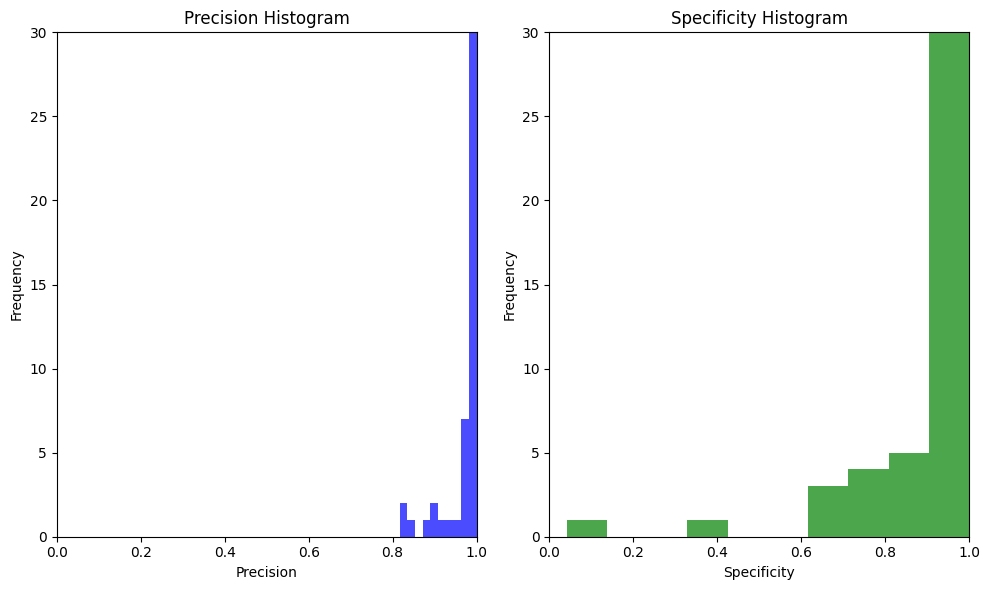

In [9]:
TP = []
FP = []
TN = []
FN = []
for bnet in all_data:
    if len(all_data[bnet]["reachability"]) == 0:
        continue
    TP.append(all_data[bnet]["reachability"]["Tsd"][0])
    FP.append(all_data[bnet]["reachability"]["Tsd"][1])
    TN.append(all_data[bnet]["reachability"]["Tsd"][2])
    FN.append(all_data[bnet]["reachability"]["Tsd"][3])

print(np.arange(0, 1.1, 0.1))

plot_precision_and_specificity(TP, FP, TN, FN)